In [2]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

In [3]:
pubs_author_funder = pd.read_csv("..//..//..//data//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(literal_eval)
pubs_author_funder['funding_units'] = pubs_author_funder['funder_country'].apply(lambda x: len(x))

## reshuffle the funding units along each fundingship within each country

In [4]:
pubs_author_funder.head()

,id,author_country,funder_country,funding_units
0,30507292,[Turkey],[Turkey],1
1,30574690,"[United States, France]","[United States, United States, United States, ...",4
2,30574691,[Russia],[Russia],1
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",6
4,30585097,"[Germany, Spain]",[Spain],1


In [5]:
pubs_funder=pubs_author_funder[['id','funder_country']]
pubs_funder = pubs_funder.explode('funder_country')
pubs_funder = pubs_funder.groupby(
    ['id','funder_country']).size().reset_index(name='count')
pubs_funder.head()

,id,funder_country,count
0,30507292,Turkey,1
1,30574690,United States,4
2,30574691,Russia,1
3,30585095,Spain,6
4,30585097,Spain,1


In [12]:
pubs_funder_reshuffle=reshuffle_count(
    pubs_funder,'funder_country')
pubs_funder_reshuffle.head()

<ipython-input-11-7b37c419f6cb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cntry_df['random']=unitlist


,id,funder_country,count,random
0,30507292,Turkey,1,1
1,30590517,Turkey,1,1
2,30730821,Turkey,1,1
3,30730942,Turkey,1,1
4,30746044,Turkey,1,1


In [11]:
def reshuffle_count(data, colname):
    null_df=pd.DataFrame()
    cntrylist=data[colname].unique().tolist()
    
    for cntry in cntrylist:
        cntry_df=data[data[colname]==cntry]
        unitlist=cntry_df['count'].tolist()
        for _ in range(2):
            random.shuffle(unitlist)
        cntry_df['random']=unitlist
        null_df=pd.concat([null_df, cntry_df], ignore_index=True)
        
    return null_df

In [13]:
def convert_tolist(cntry,count):
    cntrylist=[cntry for n in range(count)]
    return cntrylist
def expand_unit_to_list(data, colname):
    data['countrylist']=data.apply(lambda x: convert_tolist(x[colname],x['random']), axis=1)
    #null_df = data.groupby('id')['countrylist'].progress_apply(sum)
    null_df = data.groupby('id')['countrylist'].sum()
    null_df = null_df.reset_index()
    null_df.columns=['id',colname]
    return null_df

In [21]:
pubs_funder_null=expand_unit_to_list(
    pubs_funder_reshuffle, 'funder_country')

In [23]:
pubs_funder_null.to_csv("pubs_funder_shuffled.csv", index=False)

## normalize the actual matrix with random funder matrix

In [26]:
cntry_cntry_df = pd.read_csv("..//..//..//data//Data//DerivedData//Derived//funding_source_target.csv")
cntry_cntry_df = cntry_cntry_df.pivot_table(
    index='source',columns='target', values='value', fill_value=0)
cntry_cntry_df.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1706.342726,0.0,0.000000,0.0,0.0,3.92619,0.0,1.997885,...,21.937491,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.5,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,20.581349,0.0,0.0,0.00000,0.0,2.650000,...,3.602381,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [27]:
cntry_out = cntry_cntry_df.sum(axis=1).reset_index(name="unitsout")
cntry_in = cntry_cntry_df.sum(axis=0).reset_index(name='unitsin')
cntry_in_out=cntry_in.merge(
    cntry_out, left_on="target",right_on="source",how="inner")
cntry_in_out.head()

,target,unitsin,source,unitsout
0,Afghanistan,95.035440,Afghanistan,23.0
1,Albania,207.108642,Albania,34.0
2,Algeria,4864.172289,Algeria,2607.0
3,Andorra,25.181734,Andorra,53.0
4,Angola,204.422412,Angola,76.0


In [26]:
def generate_null(data):
    cntry_cntry_explodelist = []
    for index, row in data.iterrows():
        units = row['funding_units']
        author_country = row['author_country']
        funding_country=row['funder_country']
        num_author = len(author_country)
        num_funder=len(funding_country)
        for author_c in author_country:
            for funder_c in funding_country:
                credit = units/(num_author*num_funder)
                templist = [funder_c,author_c, credit]
                cntry_cntry_explodelist.append(templist)
                
    cntry_cntry_null = pd.DataFrame(
        cntry_cntry_explodelist, columns=['source','target','value'])
    cntry_cntry_null = cntry_cntry_null.groupby(['source','target'])['value'].sum().reset_index()
    cntry_cntry_null = cntry_cntry_null.pivot_table(
        index='source',columns='target', values='value', fill_value=0)
    return cntry_cntry_null


In [27]:
def get_normedmatrix(indexlist, collist, actual_df, random_df):
    
    randomnormed_df = pd.DataFrame(
        index=indexlist,columns=collist)
    for ind, col in product(indexlist, collist):
        try:
            actual_value=actual_df.loc[ind,col]
        except:
            actual_value=0
        random_value=random_df.loc[ind,col]
        exp=actual_value/random_value
        randomnormed_df.loc[ind,col]=exp
    randomnormed_df = randomnormed_df.fillna(0)
    
    return randomnormed_df


In [32]:
pubs_funder_null=pubs_funder_null.merge(
    pubs_author_funder[['id','author_country']], on="id")
pubs_funder_null.head()

,id,funder_country,author_country
0,30507292,[Turkey],[Turkey]
1,30574690,"[United States, United States, United States, ...","[United States, France]"
2,30574691,[Russia],[Russia]
3,30585095,"[Spain, Spain, Spain, Spain]","[Spain, Spain]"
4,30585097,"[Spain, Spain, Spain]","[Germany, Spain]"


In [33]:
pubs_funder_null['funding_units'] = pubs_funder_null['funder_country'].apply(lambda x: len(x))
pubs_funder_null.head()

,id,funder_country,author_country,funding_units
0,30507292,[Turkey],[Turkey],1
1,30574690,"[United States, United States, United States, ...","[United States, France]",5
2,30574691,[Russia],[Russia],1
3,30585095,"[Spain, Spain, Spain, Spain]","[Spain, Spain]",4
4,30585097,"[Spain, Spain, Spain]","[Germany, Spain]",3


In [34]:
funder_null_matrix=generate_null(pubs_funder_null)
funder_null_matrix.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1671.479234,0.0,0.000000,0.0,0.0,2.069048,0.0,1.997885,...,21.439872,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,17.981349,0.0,0.0,0.000000,0.0,2.000000,...,3.285714,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [36]:
cntry_cntry_df.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.5,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.333333,...,2.299242,0.0,0.0,0.0,0.0,0.0,0.50,0.000000,0.0,0.0
Albania,0.0,8.833333,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.0,0.277778,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.00,0.000000,0.0,0.0
Algeria,0.0,0.000000,1706.342726,0.0,0.000000,0.0,0.0,3.92619,0.0,1.997885,...,21.937491,0.0,0.0,0.0,0.0,0.0,0.25,0.333333,0.0,0.0
Andorra,0.0,0.000000,0.000000,3.5,0.000000,0.0,0.0,0.00000,0.0,0.000000,...,3.900000,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0
Angola,0.0,0.000000,0.000000,0.0,20.581349,0.0,0.0,0.00000,0.0,2.650000,...,3.602381,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0


In [12]:
funderlist=cntry_cntry_df.index
authorlist=cntry_cntry_df.columns

In [35]:

fundernull_normed=get_normedmatrix(
    funderlist, authorlist, cntry_cntry_df, funder_null_matrix)

<ipython-input-27-13d4e271a30e>:11: RuntimeWarning: invalid value encountered in double_scalars
  exp=actual_value/random_value


In [37]:
fundernull_normed.head()

target,Afghanistan,Albania,Algeria,Andorra,Angola,Antarctica,Antigua & Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Vatican,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
source,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Albania,0.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000,...,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Algeria,0.0,0.0,1.020858,0.000000,0.000000,0.0,0.0,1.897583,0.0,1.000,...,1.023210,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Andorra,0.0,0.0,0.000000,1.166667,0.000000,0.0,0.0,0.000000,0.0,0.000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.000000,0.000000,1.144594,0.0,0.0,0.000000,0.0,1.325,...,1.096377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
fundernull_normed = pd.read_csv("fundernull_normed.csv", index_col=0)

In [4]:
import matplotlib.colors as colors
divnorm = colors.DivergingNorm(vmin=0, vcenter=1, vmax=11)

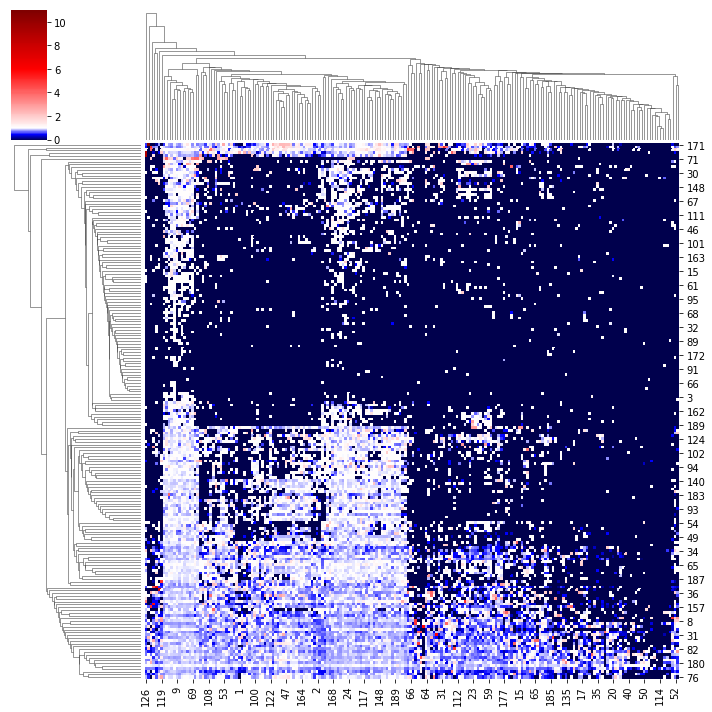

In [22]:
g = sns.clustermap(fundernull_normed.values,norm=divnorm,cmap="seismic")


In [24]:
top20 = cntry_in_out.sort_values(
    by='unitsout',ascending=False).head(20).source

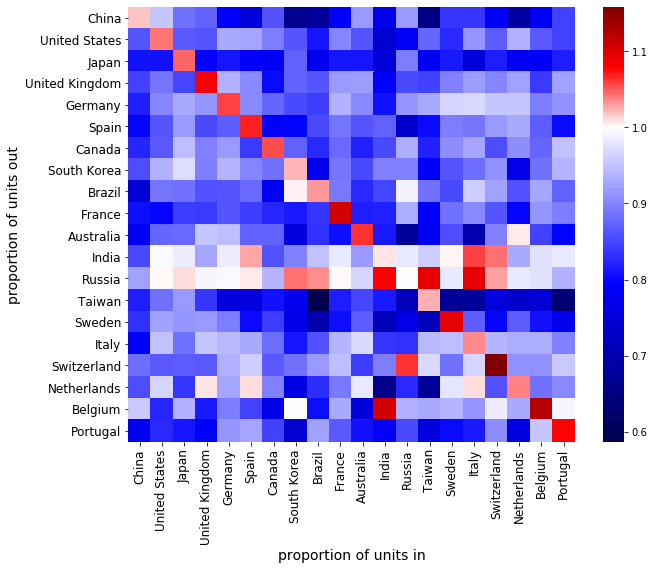

In [25]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(fundernull_normed.loc[top20,top20],norm=divnorm,cmap="seismic")
plt.ylabel("proportion of units out", fontsize=14)
plt.xlabel("proportion of units in", fontsize=14)
plt.tick_params(axis='both',labelsize=12)